MNIST classifier exercise from Hands on Machine Learning in Tensorflow and Scikit-Learn
----

First, we'll download the MNIST dataset.

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist # Get a peek at the data

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

To explain:
----
DESCR is a description of the dataset

data is the feature array

target is the array of labels.

In [4]:
# Assign the data and target values to variables.
X, y = mnist["data"], mnist["target"]

# Dimensions of the members
print("X: " + str(X.shape)) # Each image is 28x28 = 784 features.
print("Y: " + str(y.shape)) # Each image has a single target value

X: (70000L, 784L)
Y: (70000L,)


Now, let's reconstruct a member of the set and get a feel for the data.
----

The target identity is:5.0


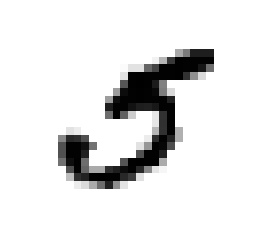

In [41]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Extract the 36 thousandth image of the dataset, and return its dimensions.
some_digit = X[36000] 
some_digit_image = some_digit.reshape(28, 28)

# Plot the image, and output the target identity
print("The target identity is:" + str(y[36000]))
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Before continuing with the data:
----
Split into training and testing sets, and randomly shuffle them.

In [42]:
import numpy as np

# Split the sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Now, first, we'll train a binary classifier to recognize the 1 that we extracted in the dataset.
----

In [54]:
from sklearn.linear_model import SGDClassifier

# Extract the 5's
y_train_5 = (y_train ==5)
y_test_5  = (y_test  ==5)

# Fit a Stochastic Gradient Descent model to the dataset to identify 5's
sgd_clf   = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# See the classification of the 1:
print("Classifying the 5: " + str(sgd_clf.predict([some_digit])))

# Check how it classifies a 1
five = X[12345]
print("Classifying the 1: " + str(sgd_clf.predict([five])))

Classifying the 5: [ True]
Classifying the 1: [False]


Performance Measures
----
First, let's check out $\textbf{Stratified K-Fold}$

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

# Use the stratified k-fold to make 3 test/train splits.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf     = clone(sgd_clf)            # The learning function
    X_train_folds = X_train[train_index]      # The training data for X
    y_train_folds = (y_train_5[train_index])  # The training data for y
    X_test_fold   = X_train[test_index]       # The testing data for X
    y_test_fold   = (y_train_5[test_index])   # The testing data for y
    
    clone_clf.fit(X_train_folds, y_train_folds)     # Fit to this fold's training data
    y_pred = clone_clf.predict(X_test_fold)         # Classify the testing data
    n_correct = sum(y_pred == y_test_fold)          # Sum up the classifications that were equal to actual
    print(float(n_correct) / float(len(y_pred)))    # After all of the work on this fold, output the percent correct

0.9472
0.9553
0.96625


Now, let's check out the $\textbf{cross_val_score()}$ to evaluate our model using $\textbf{K-Fold Cross Validation}$.

In [56]:
from sklearn.model_selection import cross_val_score

# Get the cross validation score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9472 ,  0.9553 ,  0.96625])

Now, it's known that $\textbf{accuracy}$ isn't always the fairest assessment of a model.

Check out this toy example, naively scoring everything as not-5.

In [57]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
        
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.90915,  0.9081 ,  0.9117 ])

It's important to note that the $\textbf{accuracy}$ for the model is still above 87% for a totally naive classifier.

A much better way to evaluate performance is the $\textbf{confusion matrix}$.

In [58]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Obtain a clean prediction for the data
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Create the confusion matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53865,   714],
       [ 1911,  3510]])

From the $\textbf{confusion matrix}$, we can derive greater metrics for goodness of fit:

$\textbf{Precision:}$ $\frac{TP}{TP + FP}$ which is a measure of how often the data classified is correct to the target.

$\textbf{Recall:}$ $\frac{TP}{TP + FN}$ which is a measure of how much relevant information is retrieved by the algorithm.

In [59]:
from sklearn.metrics import precision_score, recall_score

print("Precision " + str(precision_score(y_train_5, y_train_pred)))
print("Recall " + str(recall_score(y_train_5, y_train_pred)))

Precision 0.830965909091
Recall 0.647482014388


This leads us to the $\textbf{$F_{1}$ score}$ = $\frac{2}{\frac{1}{precision} + \frac{1}{recall}}$

Which is a balance between precision and recall.

In [61]:
from sklearn.metrics import f1_score

print("F1 score classifying 5's: " + str(f1_score(y_train_5, y_train_pred)))

F1 score classifying 5's: 0.727838258165
